# Uppvärmning

Först måste vi göra ändringar till csv filens data som t.ex lägga till make $i$ kolunnen 

In [33]:
import pandas as pd
from ast import literal_eval as tolist
from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import loggamma
from statinlprojekt import Theta_MoM_skattning, AlphaBeta_MoM_skattning, tricks_data, get_parameters_tricks, get_avg_alpha_beta_tricks, Lcq_ids
from simulate import xparams, print_dic
from metro import metropolis


In [34]:

# pdf = lambda x: 2*np.exp(-2*x);
# Finv = lambda u: -(1/2)*np.log(u)
df = pd.read_csv("SLS22.csv") #data frame 
Lcq_ids = ["Majerus", "Oliveira","Decenzo","Santiago", "Papa", "Eaton", "Mota", "Shirai", 
           "Jordan", "Hoefler", "Hoban", "Gustavo", "Ribeiro C", "O’neill", "Foy", "Midler"]
Lcq_ids = ["Majerus", "Oliveira", "O’neill", "Santiago", "Papa", "Ribeiro C", "Mota", "Shirai",
           "Jordan", "Hoefler", "Foy", "Midler", "Gustavo", "Hoban", "Eaton", "Decenzo"]
def init_normal_dataframe():
    ndf = df
    ndf["run 1"] = [x/10 for x in df["run 1"]]
    ndf["run 2"] = [x/10 for x in df["run 2"]]
    ndf["trick 1"] = [x/10 for x in df["trick 1"]]
    ndf["trick 2"] = [x/10 for x in df["trick 2"]]
    ndf["trick 3"] = [x/10 for x in df["trick 3"]]
    ndf["trick 4"] = [x/10 for x in df["trick 4"]]
    ndf["trick 5"] = [x/10 for x in df["trick 5"]]
    ndf["trick 6"] = [x/10 for x in df["trick 6"]]
    ndf["make 1"] = [int(bool(x)) for x in df["trick 1"].values.tolist()]
    ndf["make 2"] = [int(bool(x)) for x in df["trick 2"].values.tolist()]
    ndf["make 3"] = [int(bool(x)) for x in df["trick 3"].values.tolist()]
    ndf["make 4"] = [int(bool(x)) for x in df["trick 4"].values.tolist()]
    return ndf
ndf = init_normal_dataframe()

ids = []
for name in ndf['id']:
    if name not in ids:
        ids.append(name)

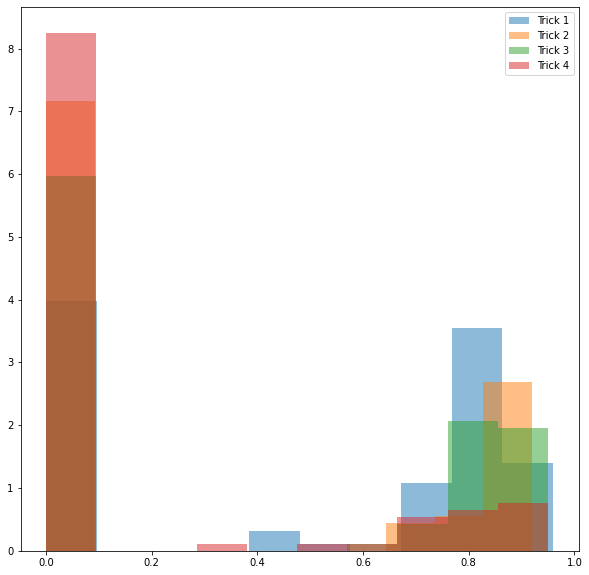

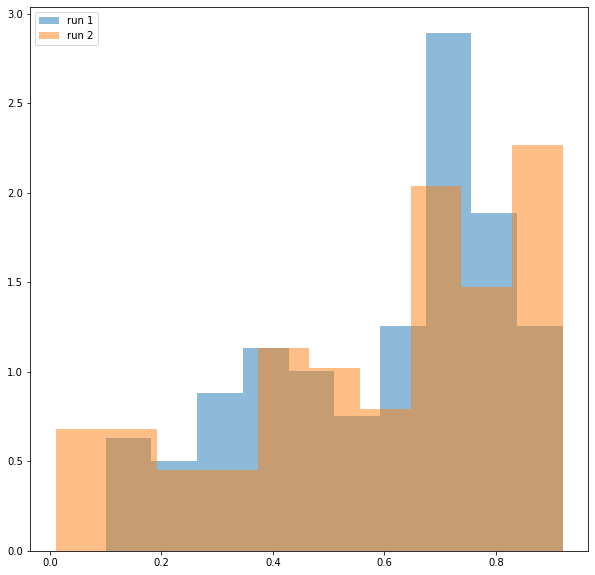

No handles with labels found to put in legend.


Skattade sannolikhet att z>0.6:  0.9615384615384616


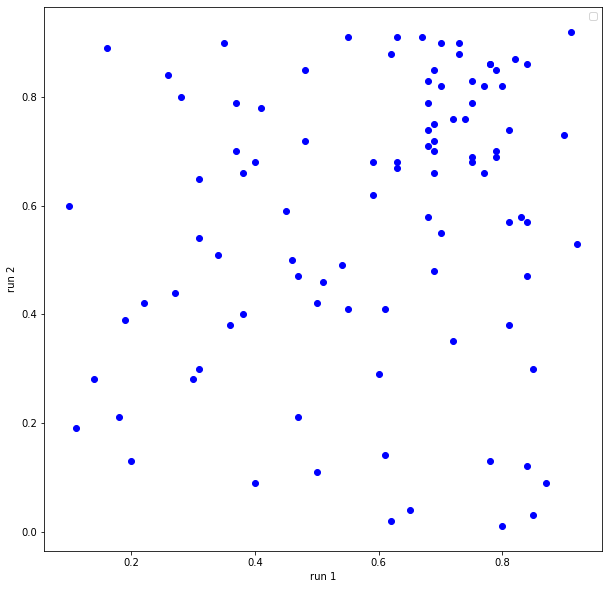

In [58]:
def make_histogram():
    plt.figure(figsize=(10, 10))
    plt.hist(ndf["trick 1"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 1")
    plt.hist(ndf["trick 2"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 2")
    plt.hist(ndf["trick 3"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 3")
    plt.hist(ndf["trick 4"], density=True, histtype='stepfilled', alpha=0.5, label = "Trick 4")
    plt.legend()
    plt.show()

def make_histogram_runs():
    # fig, ax = plt.subplots(1, 1)
    plt.figure(figsize=(10, 10))
    plt.hist(ndf["run 1"], density=True,
             histtype='stepfilled', alpha=0.5, label="run 1")
    plt.hist(ndf["run 2"], density=True,
             histtype='stepfilled', alpha=0.5, label="run 2")
    plt.legend()
    plt.show()

def calculate_Q1_partd():
    count_lands = ndf["make 1"].values.tolist().count(1) + ndf["make 2"].values.tolist().count(1) +ndf["make 3"].values.tolist().count(1) + ndf["make 4"].values.tolist().count(1) 
    count_bigger_than6 = 0;
    alltricks = ndf["trick 1"].values.tolist() + ndf["trick 2"].values.tolist() + ndf["trick 3"].values.tolist() + ndf["trick 4"].values.tolist()
    for x in alltricks:
        if x>0.6:
            count_bigger_than6+=1
    return float(count_bigger_than6)/float(count_lands)


def plot_run1_run2():
    plt.figure(figsize=(10, 10))
    plt.scatter(ndf["run 1"],ndf["run 2"],color='blue', marker='o')
    plt.xlabel('run 1')
    plt.ylabel('run 2')
    plt.legend()
    plt.show()
make_histogram()
make_histogram_runs()
print("Skattade sannolikhet att z>0.6: ", calculate_Q1_partd())
plot_run1_run2()

# En frekventistisk modell

### (a) Finding $\theta$ 

Let $x_{i[n]} = (x_{i1}, x_{i2}, \ldots, x_{in})^T$ be our sample from all the tricks skateboarder $i$ performed.

$$
L(\theta_i, \alpha_i, \beta_i | x_{i[n]}) = \prod_{j=1}^n f_{x_i}(x_{ij}) = \prod_{j}^n (1 - \theta_i) \mathbb{I}(x=0) (x_{ij}) + \theta_i f_{Z_i}(x_{ij}) \mathbb{I}(x \neq 0)(x_{ij})
$$

$$
\Longrightarrow
$$

$$
L(\theta_i, \alpha_i, \beta_i | x_{i[n]}) = (1 - \theta_i)^{n-m} \theta_i^m \prod_{j=1}^n\left(f_{Z_i}(x_{ij}) \mathbb{I}(x \neq 0)(x_{ij}) + \mathbb{I}(x = 0)(x_{ij})\right)
$$

where $m = \sum_{j=1}^n \mathbb{I}(x \neq 0)(x_{ij})$, indicating how many times $x_{i}$ is not zero (i.e., the number of times skateboarder $i$ landed the trick).

Now we take the log-likelihood function:

$$
\Longrightarrow \log(L) = (n-m)\log(1-\theta_i) + m\log(\theta_i) + \sum_{j=1}^n \log \left(f_{Z_i}(x_{ij}) \mathbb{I}(x \neq 0)(x_{ij}) + \mathbb{I}(x = 0)(x_{ij})\right) \tag{loglike}
$$

$$
\Longrightarrow \partial_{\theta_i}\log(L) = \frac{m-n}{1-\theta_i} + \frac{m}{\theta_i} = 0 \tag{blah}
$$

$$
\Longrightarrow \frac{m-n\theta_i}{\theta_i(1-\theta_i)} = 0 \Longrightarrow \hat{\theta_i} = \frac{m}{n} \tag{MLE result}
$$

The Maximum Likelihood Estimation (MLE) for the Bernoulli distribution parameter $V_i$, $\hat{\theta_i} = \text{argmax}_{\theta \in \Omega} L(\theta_i|v_{i[n]}) = \bar{v_i}$, would give us the same result. This is because we can transform the sample $x_{i[n]} \rightarrow v_{i[n]}$ using \cref{properties} with $v_i = \mathbb{I}(x \neq 0)(x_i)$. This means that $m = \sum_{j=1}^n v_i$, and thus, \cref{MLE result} coincides with the MLE of the Bernoulli distribution. 

Since every skateboarder landed at least one trick we can find estimations $\theta$ for everybody.
Here is the py function that I made to implement this estimation.


In [ ]:
def Theta_MoM_skattning(xdata):
    vdata = xdata>0.0 # creates the v data by taking bool of all data points in x
    return np.mean(vdata)

##### (b) finding $\alpha_i$ $\beta_i$

Note that from \cref{loglike}, $\sum_{j=1}^n \log \left(f_{Z_i}(x_{ij})\mathbb{I}(x \neq 0)(x_{ij})\right) = \sum_{j=1}^n \log \left(f_{Z_i}(x_{ij})\mathbb{I}(x \neq 0)(x_{ij})\right)$, since $\log(1) = 0$.

We know that

$$
\text{argmax}_{\alpha, \beta \in \Omega}\log(L) = \text{argmax}_{\alpha, \beta \in \Omega}\sum_{j=1}^n \log \left(f_{Z_i}(x_{ij})\mathbb{I}(x \neq 0)(x_{ij})\right)
$$

which is equivalent to

$$
\text{argmax}_{\alpha, \beta \in \Omega} \log(L(\alpha, \beta|z_{i[k]}))
$$

since $z$ is the sample containing all the tricks that landed, $z_{i[k]} = (z_{i1}, \ldots, z_{ik})^T = \{x_{ij} \in x_{i[n]} : x_{ij} \neq 0\}$.

So, we only need to maximize the log-likelihood of the beta distribution parameters given the data from $Z_i$.

$$
\begin{align*}
\begin{cases}
\partial_{\alpha}\log(L(\alpha, \beta | z_{i[k]})) = \sum_{j=1}^k \partial_\alpha \log(f(z_{ij})) = 0 \\
\partial_{\beta}\log(L(\alpha, \beta | z_{i[k]})) = \sum_{j=1}^k \partial_\beta \log(f(z_{ij})) = 0
\end{cases}
\end{align*}
$$

$$
\begin{align*}
\text{:: } \partial_\alpha\log(f(z_{ij})) = \partial_\alpha\log \left( \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \cdot \Gamma(\beta)} \cdot z_{ij}^{\alpha-1} \cdot (1-z_{ij})^{\beta-1}\right) \\
= \partial_\alpha \left(\log \Gamma(\alpha + \beta) - \log\Gamma(\alpha) - \log \Gamma(\beta) + (\alpha-1) \log z_{ij} + (\beta-1)\log (1-z_{ij}) \right)
\end{align*}
$$

$$
\begin{align*}
\partial_\alpha\log(f(z_{ij})) = \psi(\alpha+\beta) - \psi(\alpha) + \log z_{ij} \text{  where  } \psi = \Gamma ' / \Gamma
\end{align*}
$$

(Similarly for $\partial_\beta \log f(z_{ij})).$

$$
\begin{align*}
\Rightarrow
\begin{cases}
\partial_{\alpha}\log L = k\psi(\alpha+\beta)-k\psi(\alpha) + \sum_{j=1}^k\log(z_{ij}) = 0 \\
\partial_{\beta}\log L = k\psi(\alpha+\beta)-k\psi(\beta) + \sum_{j=1}^k\log(1-z_{ij}) = 0
\end{cases}
\end{align*}
$$

### Skatta $\alpha,\beta$ (misslyckad försök med numeriska metoder)
Jag härledde följande ekvationer för ML skattningen
$$\left\{\begin{matrix}
        \partial_{\alpha}\log L= k\psi(\alpha+\beta)-k\psi(\alpha) + \sum_{j=1}^k\log(z_{ij}) = 0
        \\ \\ \partial_{\beta}\log L= k\psi(\alpha+\beta)-k\psi(\beta) + \sum_{j=1}^k\log(1-z_{ij})) = 0
        \end{matrix}\right.
        $$


Jag försökte lösa ekvationssystemet med newton rhapson
$\mathbf{x_n} = \mathbf{x_{n-1}} - J^{-1}F(x_{n-1})$

In [ ]:
import numpy as np
from scipy.special import polygamma, gammaln, psi
from statinlprojekt import AlphaBeta_MoM_skattning
PsiPrime = lambda x: polygamma(1,x)

def beta_likelihood(alpha, beta, data):
    log_likelihood = gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta)) + np.sum((alpha - 1) * np.log(data) + (beta - 1) * np.log(1 - data))
    return log_likelihood

def grad_F(alpha: float,beta: float,data: np.array): #want this to be 0¨
    data = np.array(data)
    k = len(data)
    partial_alpha = psi(alpha+beta) -psi(alpha) + np.sum(np.log(data))/k
    partial_beta = psi(alpha+beta) - psi(beta) + np.sum(np.log(1-data))/k
    result = np.array([partial_alpha,partial_beta])
    return result

def Jac(alpha,beta):
    result = np.array(
        [
            [PsiPrime(alpha+beta) - PsiPrime(alpha), PsiPrime(alpha+beta)],
            [PsiPrime(alpha+beta), PsiPrime(alpha+beta)-PsiPrime(beta)]
        ])
    return result

def newton_raphson(data):
    data = np.array([x for x in data if x>0])
    alpha_beta = AlphaBeta_MoM_skattning(data)  # Initial guess using the method of moments
    tol = 1e-6  # Tolerance for convergence
    max_iter = 100  # Maximum number of iterations
    iter_count = 0
    while iter_count < max_iter:
        alpha, beta = alpha_beta
        likelihood_gradient = grad_F(alpha, beta, data)
        hessian = Jac(alpha, beta)
        alpha_beta -= np.linalg.solve(hessian, likelihood_gradient)
        if np.max(np.abs(likelihood_gradient)) < tol:
            break
        iter_count += 1

    return alpha_beta



men jag kunde inte få detta att konvergera och insåg att det var en dålig metod. Det bara försämrade MoM skattningen som jag använde som startgissningen.
Det medför sig en del problem som ökar systematiska felet genom numerisk fel. 
Vi behåller riktighet i punktskattningen genom att använda moment metoden istället. 

##### Skatta $\alpha,\beta$ (moment of methods)

Resultatet som jag fick från MoM var betydlig mer pålitlig
$$\left\{\begin{matrix}
        \tilde{\alpha_i} = \bar{z_i}\left(\frac{\bar{z_i}(1-\bar{z_i})}{S^2}-1\right)
        \\ \tilde{\beta_i} = (1-\bar{z_i})\left(\frac{\bar{z_i}(1-\bar{z_i})}{S^2}-1\right)
    \end{matrix}\right.$$

Vi kan dock endast få en skattning för en skateboardåkare $i$ när stickprovsvariansen är större än 0.

Därför när $S^2==0$ för en viss skatebordeåkare pga av brist på datan använde jag medelvärdet av samtliga stickprovsvariansen som approximation dvs $S^2 \approx \bar{S^2}$

In [39]:
def get_avg_svariance():
    average_svariance = 0
    for eachdata in tricks_data.values():
        a = np.array([k for k in eachdata if k>0])
        average_svariance+=np.var(a)
    average_svariance/=len(ids)
    return average_svariance
average_svariance = get_avg_svariance()

Which I can use in the py function I implemented for this specialized version of MoM

In [ ]:
def AlphaBeta_MoM_skattning(xdata):
    data = [x for x in xdata if x>0] # creates the z_i data by excluding the 0s in the x_i data
    if len(data)==1: # after we remove all the zeros we might only have one data points for z_i. Here's where I made my contingency.
        svariance = average_svariance #
    else:
        svariance = np.var(data, ddof=1) 
    m = np.mean(data)
    alpha_0 = m*(m*(1-m)/svariance-1)
    beta_0 = (1-m)*(m*(1-m)/svariance-1)
    return np.array([alpha_0,beta_0])   


Which gives me the following estimates of theta, alpha, and beta

In [66]:
from statinlprojekt import get_parameters_tricks
def display_params(params):
    df = pd.DataFrame(params)
    df = df.transpose()
    df.columns = ["Theta MoM", "Alpha MoM", "Beta MoM"]
    print(df)
display_params(get_parameters_tricks())

           Theta MoM   Alpha MoM    Beta MoM
Berger      0.166667   79.205000   29.295000
Papa        0.437500   19.015717    5.408140
Pudwill     0.250000   19.926203   13.100653
Shirai      0.400000   17.897646    2.044021
Mota        0.250000   15.744444    4.440741
Ribeiro G   0.541667   36.928595    5.109210
Decenzo     0.437500   20.844062    4.356013
Hoefler     0.437500   27.765683    8.028015
Foy         0.500000   42.849597    7.561694
Hoban       0.400000   94.126868   13.140218
Midler      0.333333   32.590503    7.769253
Milou       0.450000   33.178979    6.163684
Rodriguez   0.500000   44.130319   14.710106
O’neill     0.250000  834.829722  155.086944
Oliveira    0.416667   54.944118   14.255023
Ribeiro C   0.250000  129.594767   37.265448
Gustavo     0.400000   61.713863   15.308119
Huston      0.375000   94.577778   12.088889
Santiago    0.083333   31.070045   35.036433
Joslin      0.450000  228.443638   45.323704
Jordan      0.400000   20.072141    3.166228
Horigome  

### (c) Punktskattning för $Y_i$

In [68]:
from statinlprojekt import get_parameters_runs
def display_params(params):
    df = pd.DataFrame(params)
    df = df.transpose()
    df.columns = ["Alpha_y MoM", "Beta_y MoM"]
    print(df)
display_params(get_parameters_runs())

           Alpha_y MoM   Beta_y MoM
Berger        2.265510     3.722622
Papa          1.829142     1.748642
Pudwill       3.423002    10.939245
Shirai        1.594273     0.956564
Mota          3.301811     3.723318
Ribeiro G     4.682587     1.739247
Decenzo       3.569568     2.429706
Hoefler       1.454558     0.800570
Foy           2.845229     3.317722
Hoban         3.205587     1.850544
Midler        0.973483     0.618042
Milou         5.865345     2.537728
Rodriguez     2.379759     2.552384
O’neill       0.424490     0.518821
Oliveira      4.396292     3.294015
Ribeiro C     1.405666     1.189409
Gustavo       1.046373     0.730152
Huston        4.552489     1.321690
Santiago      2.170197     3.515908
Joslin        9.455512     3.253509
Jordan        3.172789     1.080279
Horigome     12.905240     3.327766
Suciu         1.882106     1.013442
Wair          1.021905     0.740000
Wright      298.265000   730.235000
Majerus       1.212651     1.709400
Silvas        0.789174     0

### (d) simulering för frekventistisk modell

The actual finalists are
 ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']  has freq:  26  which approx equals:  0.52 %
The mode is
 {'Eaton', 'Jordan', 'Hoban', 'Shirai'}  has freq:  50  which approx equals:  1.0 %


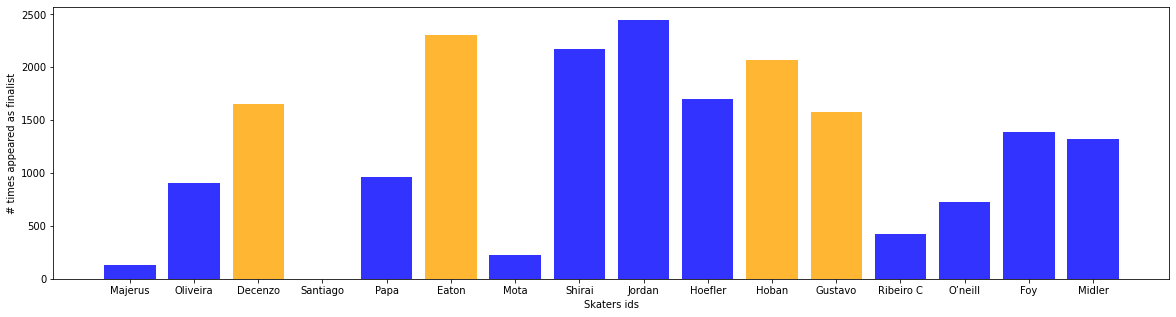

In [54]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from statinlprojekt import get_parameters_tricks, get_parameters_runs, Lcq_ids, ids, init_trick_data


actual_finalists = ["Gustavo", "Hoban", "Eaton", "Decenzo"]

Lcq_ids_index = {Lcq_ids[e]:e for e in range(len(Lcq_ids))}

def get_LCQ_params():
    resultx = get_parameters_tricks()
    resulty = get_parameters_runs()
    for e in ids:
        if e not in Lcq_ids:
            resultx.pop(e)
            resulty.pop(e)
    return resultx, resulty
def print_dic(dic):
    for keys,values in dic.items():
        print(keys,values)

xparams, yparams = get_LCQ_params()

def sort_with_indices(arr):
    indexed_arr = list(enumerate(arr))
    sorted_arr = sorted(indexed_arr, key=lambda x: x[1])
    indices = [index for index, _ in sorted_arr]
    return indices

def total_betyg(tricks, runs):
    sorted_trick = sorted(tricks)
    return (sorted_trick[-2]+sorted_trick[-1]) + max(runs)


def sim_trick_betyg(theta,alpha,beta): # generates X_i
    V = np.array(np.random.choice([0,1], 4, p = [1-theta,theta]))
    Z = np.array(np.random.beta(alpha,beta,4))
    X = [0,0,0,0]
    for i in range(len(X)):
        X[i] = Z[i]*V[i]
    return X

def get_rand_LCQ(): # returns an array of n LCQs. An LCQ is an array representing the total betyg of each skateboarder 
    new_LCQ = {}
    for name in Lcq_ids:
        x_theta,x_alpha,x_beta = xparams[name][0],xparams[name][1],xparams[name][2]
        y_alpha,y_beta = yparams[name][0],yparams[name][1]
        skaters_tricks = sim_trick_betyg(x_theta,x_alpha,x_beta)
        skaters_runs = np.random.beta(y_alpha,y_beta,2) # generates 2 runs
        new_LCQ[name] = total_betyg(skaters_tricks, skaters_runs)
    return new_LCQ


def get_rand_finalists():
    rand_LCQ = get_rand_LCQ()
    sorted_players = sorted(rand_LCQ.items(), key = lambda x:x[1])
    return [sorted_players[-4][0],sorted_players[-3][0],sorted_players[-2][0],sorted_players[-1][0]]


def most_common_set(set_list):
    set_counts = Counter(frozenset(s) for s in set_list)
    most_common_set, count = set_counts.most_common(1)[0]
    return set(most_common_set), count

def most_common_array(arrays):
    tuple_arrays = [tuple(inner_list) for inner_list in arrays]
    array_counts = Counter(tuple_arrays)
    most_common_tuple, count = array_counts.most_common(1)[0]
    most_common_array = list(most_common_tuple)
    return most_common_array, count


def make_finalist_histogram():
    winner_count = {player : 0 for player in Lcq_ids}
    finalist_array = []
    for i in range(5000):
        new_W = get_rand_finalists()
        finalist_array.append(new_W)
        for e in new_W:
            winner_count[e] += 1

    def disp_most_common_finalists():
        finalist_array_sets = [set(finalists) for finalists in finalist_array]
        actual_finalists_freq = finalist_array_sets.count(set(actual_finalists))
        print("The actual finalists are\n", actual_finalists, " has freq: ", actual_finalists_freq, " which approx equals: ",100*actual_finalists_freq/5000,"%")
        most_common_finalists, freq = most_common_set(finalist_array_sets)
        print("The mode is\n", most_common_finalists, " has freq: ", freq, " which approx equals: ", 100*freq/5000,"%")


    disp_most_common_finalists()
    plt.figure(figsize=(20, 5))
    colors = ['orange' if x in actual_finalists else 'blue' for x in Lcq_ids]
    plt.bar(Lcq_ids, [winner_count[name] for name in Lcq_ids], color=colors, alpha=0.8)
    plt.xlabel("Skaters ids")
    plt.ylabel("# times appeared as finalist")
    plt.show()

if __name__=="__main__":
    make_finalist_histogram()


# En bayesiansk modell

### (a) Apriori

We need to propose a joint apriori distribution for $[\Theta_i, A_i, B_i]^T$.

**Apriori for $\Theta$**
We know that $\theta$ represents how likely the skateboarder is to land the trick, and it's a value between 0 and 1. We have no strong opinions about $\theta$ before observing the data, so we use a non-informative prior.

$$f(\theta_i) \propto 1$$

**Apriori for $A, B$**
We have no good reason to assume that $A \perp\!\!\!\!\perp B$, so we need a proper joint distribution with support $\alpha, \beta \in (0,\infty] \times (0,\infty]$.

To achieve this, we reformulate the distribution in terms of its mean $\mu$ and a measure of precision $\kappa$. For $X \sim \mathrm{Beta}(\alpha, \beta)$, we have:

$$\mu = \frac{\alpha}{\alpha + \beta} \text{ and } \kappa = \alpha + \beta + 1$$

$\kappa$ is a measure of precision for the distribution as it is inversely proportional to the variance:

$$\mathrm{Var}[X] = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)} = \frac{\mu(1 - \mu)}{\kappa}$$

We can then specify a distribution $[\mu, \kappa]^T$ (as part of a hierarchy) and then transform this distribution back into the parameters $\alpha$ and $\beta$ to obtain a distribution for $[A, B]^T$.

We adopt the hierarchical model:

$$\kappa | \mu \sim \mathrm{Gamma}(\theta_h, \lambda_h), \mu \sim \mathrm{U}(0,1)$$

A change of variables gives us the prior distribution for the parameters $\alpha$ and $\beta:

$$f_{A, B}(\alpha, \beta) = \frac{\lambda_h^{\theta_h}}{\Gamma(\theta_h)} (\alpha + \beta + 1)^{\theta_h - 1} e^{-\lambda_h(\alpha + \beta + 1)} (\alpha + \beta)^{-1}$$
where $\lambda_h$ and $\theta_h$ are hyperparameters 

We assume $\Theta_i \perp\!\!\!\!\perp A_i, B_i$ for all $i$, so

$$f(\theta_i, \alpha_i, \beta_i) = f(\theta_i)f(\alpha_i, \beta_i)$$

We need to however choose good values for $\lambda_h$ and $\theta_h$ when we do metropolis later. Since the precision is given by $\kappa = \alpha+\beta+1$ I used the 
average MoM estimations $\kappa = \tilde{\alpha}+\tilde{\beta}+1$ 

and chose my hyperparameters as $\lambda=1$ and $\theta = \lambda\kappa = \lambda(\tilde{\alpha}+\tilde{\beta}+1)$

In [ ]:
def get_avg_alpha_beta_tricks():
    params = list(get_parameters_tricks().values())
    alphas = [params[i][1] for i in range(len(params))]
    betas = [params[i][2] for i in range(len(params))]
    medel_alpha, medel_beta = np.mean(alphas), np.mean(betas)
    return [medel_alpha,medel_beta]

### (b) Aposteriori och skattning för $X_i$

$f(\theta_i, \alpha_i,\beta_i|x_i) \propto f(\theta_i)f(\alpha_i,\beta_i) f(x_i|\theta_i,\alpha_i,\beta_i)\propto f(\alpha_i,\beta_i) f(x_i|\theta_i,\alpha_i,\beta_i)$


I'll use the log aposteriori $\log f (\theta_i, \alpha_i,\beta_i|x_i) = \log f(\alpha_i,\beta_i) + \log f(x_i|\theta_i,\alpha_i,\beta_i)$ instead to simplify calculations in the metropolis algorithim.
 
The data pdf $\log f(x_i|\theta_i,\alpha_i,\beta_i)$ is implemented as `log_datafördelning(data,theta,alpha,beta)`

and the prior pdf $\log f(\theta_i)f(\alpha_i,\beta_i)$ is implemented as `log_prior(alpha,beta)`


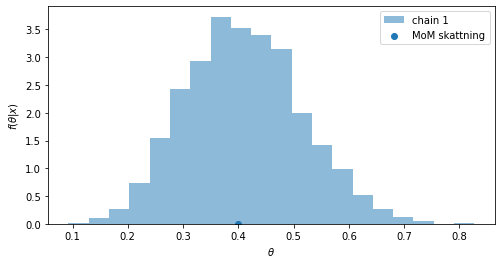

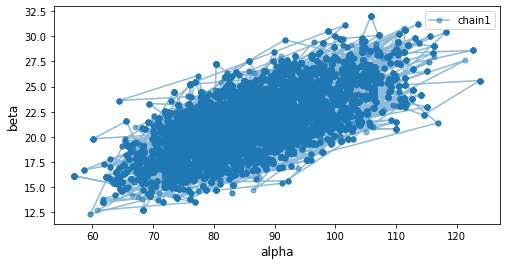

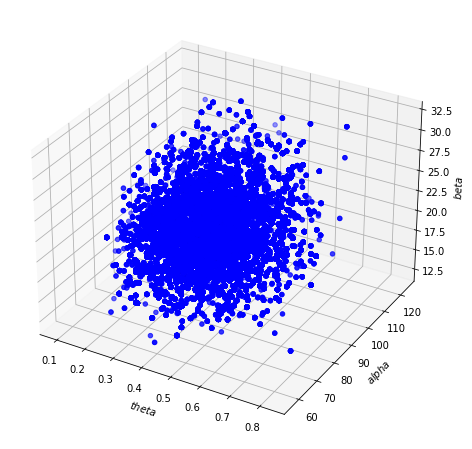

MoM skattning för theta,alpha,beta för Gustavo tricks:  [0.4, 61.713862778871274, 15.308118848425167]
Bayes skattning för theta,alpha,beta: Gustavo tricks 0.4091602186974797 86.49217636217077 21.315016234049597


In [65]:

from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import loggamma
from statinlprojekt import Theta_MoM_skattning, AlphaBeta_MoM_skattning, tricks_data, get_parameters_tricks, get_avg_alpha_beta_tricks


def log_datafördelning(data,theta, alpha,beta):
    log_beta_pdf = lambda x, alpha, beta: loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1)*np.log(x) + (beta - 1)*np.log(1 - x)
    DF = 0
    for x in data:
        if x==0:
            DF+= np.log(1-theta)
        else:
            DF+= log_beta_pdf(x,alpha,beta) + np.log(theta)
    return DF

avg_alpha_beta_tricks = get_avg_alpha_beta_tricks()

def log_prior(alpha, beta):
    lambd = 1
    thet = lambd*(sum(avg_alpha_beta_tricks)+1)
    return np.log(thet**lambd) - loggamma(thet) + (thet - 1)*np.log(alpha + beta + 1) - lambd*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior(data,theta, alpha, beta):
    log_p = log_prior(alpha, beta)
    return log_p+log_datafördelning(data,theta,alpha,beta)


def make_contour_plot(data):
    theta = Theta_MoM_skattning(data)
    alpha_grid = np.linspace(0.1, 100, 100)
    beta_grid = np.linspace(0.1, 60, 100)
    log_posterior_grid = [[log_posterior(data,theta, alpha, beta)for alpha in alpha_grid] for beta in beta_grid]
    posterior_grid = np.exp(log_posterior_grid - np.max(log_posterior_grid))
    plt.figure(figsize=(10, 6))
    plt.contour(alpha_grid, beta_grid, posterior_grid)
    plt.xlabel(r"$\alpha$", fontsize=12)
    plt.ylabel(r"$\beta$", fontsize=12)
    plt.title("Contour plot")
    plt.show()


def method_moments(data):
    data = [x for x in data if x>0]
    m1 = np.mean(data)
    m2 = np.mean([x**2 for x in data])
    alpha = (m1*(m1-m2))/(m2-m1**2)
    beta = ((m1-m2)*(1-m1))/(m2-m1**2)
    return([alpha,beta])

def metropolis(data,sample_size=1e4):
    def genY(X):
        X = np.array(X)
        proposal_alpha = np.exp(np.log(X[0]) + delta * stats.norm.rvs())
        proposal_beta = np.exp(np.log(X[1]) + delta * stats.norm.rvs())
        proposal_theta = stats.uniform.rvs()
        return np.array([proposal_alpha,proposal_beta,proposal_theta])

    n_samples = int(sample_size)
    n_chains = 1
    delta = 0.5

    alphas = np.zeros((n_samples, n_chains))
    betas = np.zeros((n_samples, n_chains))
    thetas = np.zeros((n_samples,n_chains))

    init_guess = AlphaBeta_MoM_skattning(data)
    alphas[0] = init_guess[0] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05)) 
    betas[0] = init_guess[1] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    thetas[0] = Theta_MoM_skattning(data)

    for i in range(n_samples - 1):
        for j in range(n_chains):
            last_alpha = alphas[i, j]
            last_beta = betas[i, j] 
            last_theta = thetas[i,j]
            Y = genY([last_alpha,last_beta, last_theta])
            proposal_alpha = Y[0]
            proposal_beta = Y[1]
            proposal_theta = Y[2]
            rho = np.exp(log_posterior(data,proposal_theta, proposal_alpha, proposal_beta)) / np.exp(log_posterior(data,last_theta, last_alpha, last_beta)) # f(Y)/f(Xi-1)
            u = stats.uniform.rvs()
            if u <= rho:
                alphas[i + 1, j] = proposal_alpha
                betas[i + 1, j] = proposal_beta
                thetas[i+1, j] = proposal_theta
            else:
                alphas[i + 1, j] = last_alpha
                betas[i + 1, j] = last_beta
                thetas[i+1, j] = last_theta
    
    return thetas, alphas, betas

if __name__=="__main__":
    Example_skateboarder = "Gustavo"
    data = np.array(tricks_data[Example_skateboarder])
    
    
    thetas, alphas, betas, = metropolis(data,1e5)
    
    def make_thetas_hist():
        plt.figure(figsize=(8, 4))
        for j in range(1):
            plt.hist(thetas[:, j],bins=20, alpha=0.5, density=True, label="chain "+str(j+1))
            plt.scatter(thetas[0,j],0, label="MoM skattning")
            plt.ylabel(r'$f(\theta|x)$')
            plt.xlabel(r'$\theta$')
            plt.legend()
        plt.show()
    
    def make_alpha_beta_scatter():
        plt.figure(figsize=(8, 4))
        for j in range(1):
            plt.plot(alphas[:, j], betas[:, j], '.-', markersize=10, alpha=0.5, label="chain"+str(j+1))
        plt.legend()
        plt.xlabel('alpha', fontsize=12)
        plt.ylabel('beta', fontsize=12)
        plt.show()
    

    def Plot_3D():
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(thetas[:,0],alphas[:,0],betas[:,0], c = 'b',marker='o')
        ax.set_xlabel(r"$theta$")
        ax.set_ylabel(r"$alpha$")
        ax.set_zlabel(r"$beta$")
        plt.show()

    
    make_thetas_hist()
    make_alpha_beta_scatter()
    Plot_3D()
    print(f"MoM skattning för theta,alpha,beta för {Example_skateboarder} tricks: ",get_parameters_tricks()["Gustavo"])
    print(f"Bayes skattning för theta,alpha,beta: {Example_skateboarder} tricks",np.mean(thetas[:,0]), np.mean(alphas[:,0]), np.mean(betas[:,0]))

**Json storage**

MCMC takes a lot of computation time so I stored all my values from it in a json file.

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statinlprojekt import tricks_data, Lcq_ids
from metro import metropolis

def make_metro_file():
    thetas_16 = []
    alphas_16 = []
    betas_16 = []
    theta_means = []
    alpha_means = []
    beta_means = []
    theta_variances = []
    alpha_variances = []
    beta_variances = []
    for id in Lcq_ids:
        print(id)
        ids_data = tricks_data[id]
        thetas, alphas, betas = metropolis(ids_data, 1e4)
        
        mean_theta = np.mean(thetas[:, 0])
        mean_alpha = np.mean(alphas[:, 0])
        mean_beta = np.mean(betas[:, 0])
        
        var_theta = np.var(thetas[:, 0], ddof=1)
        var_alpha = np.var(alphas[:, 0], ddof=1)
        var_beta = np.var(betas[:, 0], ddof=1)
        
        theta_means.append(mean_theta)
        alpha_means.append(mean_alpha)
        beta_means.append(mean_beta)
        theta_variances.append(var_theta)
        alpha_variances.append(var_alpha)
        beta_variances.append(var_beta)
        
        thetas_16.append(thetas[:, 0])
        alphas_16.append(alphas[:, 0])
        betas_16.append(betas[:, 0])

    metro_results = {'ids': Lcq_ids,
                    'thetas': thetas_16,
                    'alphas': alphas_16,
                    'betas': betas_16,
                    'theta mean': theta_means,
                    'alpha mean': alpha_means,
                    'beta mean': beta_means,
                    'theta variance': theta_variances,
                    'alpha variance': alpha_variances,
                    'beta variance': beta_variances}

    metro_df = pd.DataFrame(metro_results)
    metro_df.to_json('metro_results.json')

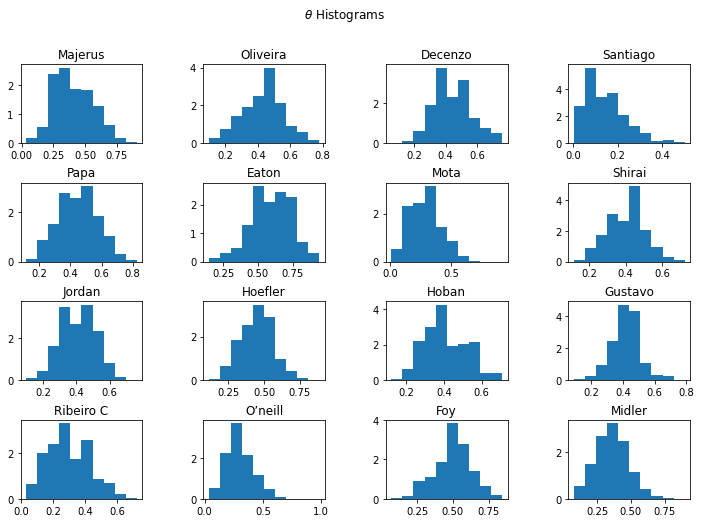

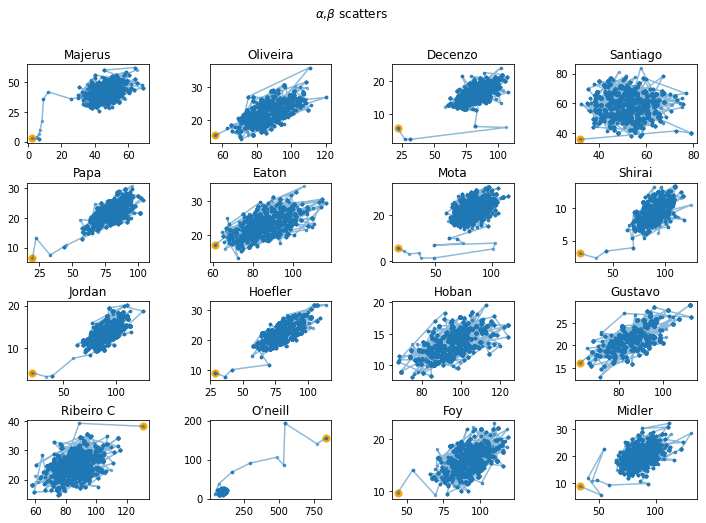

In [37]:
metro_df = pd.read_json('metro_results.json')
metro_df.set_index('ids',inplace=True)

def make_hists():
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    fig.suptitle(r"$\theta$ Histograms")
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    c = 0
    for i in range(4):
        for j in range(4):
            thetas = metro_df.loc[Lcq_ids[c]]['thetas']
            axes[i,j].hist(thetas, density=True)
            axes[i,j].set_title(Lcq_ids[c])
            c+=1
    plt.show()

def make_scatters():
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    fig.suptitle(r"$\alpha$,$\beta$ scatters")
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    c = 0
    for i in range(4):
        for j in range(4):
            alphas = metro_df.loc[Lcq_ids[c]]['alphas']
            betas = metro_df.loc[Lcq_ids[c]]['betas']
            axes[i,j].scatter(alphas[0],betas[0], marker='o',s=50,alpha=1, color='orange')
            axes[i,j].plot(alphas, betas, '.-', markersize=5, alpha=0.5)
            axes[i,j].set_title(Lcq_ids[c])
            c+=1
    plt.show()

make_hists()
make_scatters()

När vi plottar med  `moving_avg_plot()` ser vi också att löpande medelvärdet konvergerar för varje skateboardåkare.  

In [ ]:
metro_df = pd.read_json('metro_results.json')
metro_df.set_index('ids',inplace=True)

def moving_avg_plot():
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    fig.suptitle(r"moving avg")
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    c = 0
    for i in range(4):
        for j in range(4):
            alphas = metro_df.loc[Lcq_ids[c]]['alphas']
            betas = metro_df.loc[Lcq_ids[c]]['betas']
            thetas = metro_df.loc[Lcq_ids[c]]['thetas']
            iters = len(alphas)
            moving_avg_alpha = [np.mean(alphas[:k]) for k in range(1,iters)]
            moving_avg_beta = [np.mean(betas[:k]) for k in range(1,iters)]
            moving_avg_theta = [np.mean(thetas[:k]) for k in range(1,iters)]
            axes[i,j].plot(list(range(1,iters)),moving_avg_alpha, label=r"$\bar{\alpha}$")
            axes[i,j].legend()
            axes[i,j].plot(list(range(1,iters)),moving_avg_beta, label=r"$\bar{\beta}$")
            axes[i,j].plot(list(range(1,iters)),moving_avg_theta, label=r"$\bar{\theta}$")
            axes[i,j].set_title(Lcq_ids[c])
            axes[i,j].legend()
            c+=1
    plt.show()

moving_avg_plot()

**Aposterori stickprovsmedelvärdet och stickprovsvariansen för $\theta_i,\alpha_i,\beta_i$**


Följande tabell ger oss stickprovariansen och stickprovmedelvärdet för den aposteriori fördelning

In [49]:
metro_df = pd.read_json('metro_results.json')
metro_df.set_index('ids',inplace=True)
print(metro_df.drop(['thetas','alphas','betas'],axis=1))

           theta mean  alpha mean  beta mean  theta variance  alpha variance  \
ids                                                                            
Majerus      0.406160   46.549878  41.596737        0.022767       29.154994   
Oliveira     0.430292   87.364953  22.206848        0.015852       65.840365   
Decenzo      0.444973   83.716920  16.434365        0.013923       75.787533   
Santiago     0.143945   51.928637  58.984072        0.007942       49.099981   
Papa         0.447309   79.643588  21.879275        0.015104       63.667675   
Eaton        0.598752   86.114532  22.877993        0.020600       68.160294   
Mota         0.287756   84.068126  22.524696        0.015439       82.046870   
Shirai       0.405726   90.687743   9.361220        0.009642       63.384007   
Jordan       0.411510   89.917035  13.537739        0.010811       89.827895   
Hoefler      0.449740   79.897324  22.447565        0.012953       69.660903   
Hoban        0.405063   95.139344  13.45

### (c) Aposteriori och skattning för $Y_i$

Eftersom $Y_i \sim \text{Beta}(\alpha_i,\beta_i)$ ska vi använda en apriori fördelning av samma form som den alpha beta apriori i $X$.

$$f_{A, B}(\alpha, \beta) = \frac{\lambda_h^{\theta_h}}{\Gamma(\theta_h)} (\alpha + \beta + 1)^{\theta_h - 1} e^{-\lambda_h(\alpha + \beta + 1)} (\alpha + \beta)^{-1}$$
som vi använder i aposteriorin 
$$f(\alpha_i,\beta_i|\mathbf{y}_i)\propto f(\alpha_i,\beta_i)f(\mathbf{y}_i|\alpha_i,\beta_i)$$

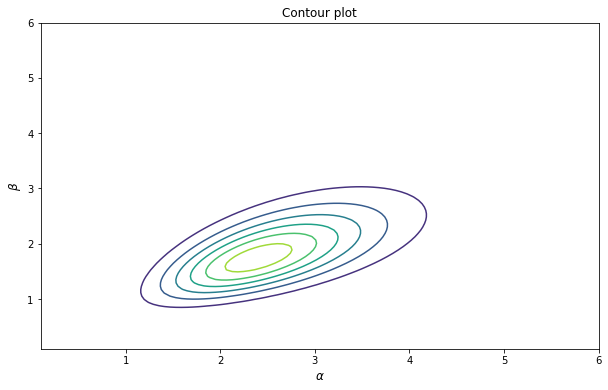

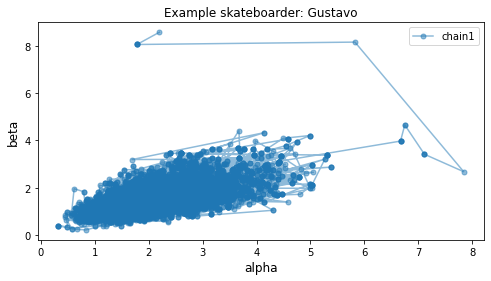

MoM estimates for alpha and beta for Gustavo's runs:  [1.0463729230651593, 0.7301515643120209]
Bayes estimates for alpha and beta for Gustavo's runs:  2.269938890834952 1.6667229529933139


In [63]:

from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import loggamma
from statinlprojekt import AlphaBeta_MoM_skattning, run_data, get_parameters_runs, get_avg_alpha_beta_runs

def log_datafördelning(data,alpha,beta):
    log_beta_pdf = lambda x, alpha, beta: loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1)*np.log(x) + (beta - 1)*np.log(1 - x)
    DF = 0
    for x in data:
        DF+= log_beta_pdf(x,alpha,beta)
    return DF

avg_alpha_beta_runs = get_avg_alpha_beta_runs()

def log_prior(alpha, beta):
    lambd = 1
    thet = lambd*(sum(avg_alpha_beta_runs)+1)
    # thet = lambd*(11)
    return np.log(thet**lambd) - loggamma(thet) + (thet - 1)*np.log(alpha + beta + 1) - lambd*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior(data,alpha, beta):
    log_p = log_prior(alpha, beta)
    return log_p+log_datafördelning(data,alpha,beta)


def make_contour_plot(data):
    alpha_grid = np.linspace(0.1, 6, 100)
    beta_grid = np.linspace(0.1, 6, 100)
    log_posterior_grid = [[log_posterior(data,alpha, beta)for alpha in alpha_grid] for beta in beta_grid]
    posterior_grid = np.exp(log_posterior_grid - np.max(log_posterior_grid))
    plt.figure(figsize=(10, 6))
    plt.contour(alpha_grid, beta_grid, posterior_grid)
    plt.xlabel(r"$\alpha$", fontsize=12)
    plt.ylabel(r"$\beta$", fontsize=12)
    plt.title("Contour plot")
    plt.show()


def method_moments(data):
    data = [x for x in data if x>0]
    m1 = np.mean(data)
    m2 = np.mean([x**2 for x in data])
    alpha = (m1*(m1-m2))/(m2-m1**2)
    beta = ((m1-m2)*(1-m1))/(m2-m1**2)
    return([alpha,beta])

def metropolisY(data,sample_size=1e4):
    def genY(X):
        X = np.array(X)
        proposal_alpha = np.exp(np.log(X[0]) + delta * stats.norm.rvs())
        proposal_beta = np.exp(np.log(X[1]) + delta * stats.norm.rvs())
        return np.array([proposal_alpha,proposal_beta])

    n_samples = int(sample_size)
    n_chains = 1
    delta = 0.5

    alphas = np.zeros((n_samples, n_chains))
    betas = np.zeros((n_samples, n_chains))

    init_guess = method_moments(data)
    alphas[0] = init_guess[0] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05)) 
    betas[0] = init_guess[1] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))

    for i in range(n_samples - 1):
        for j in range(n_chains):
            last_alpha = alphas[i, j]
            last_beta = betas[i, j] 
            Y = genY([last_alpha,last_beta])
            proposal_alpha = Y[0]
            proposal_beta = Y[1]
            rho = np.exp(log_posterior(data,proposal_alpha, proposal_beta)) / np.exp(log_posterior(data,last_alpha, last_beta)) # f(Y)/f(Xi-1)
            u = stats.uniform.rvs()
            if u <= rho:
                alphas[i + 1, j] = proposal_alpha
                betas[i + 1, j] = proposal_beta
            else:
                alphas[i + 1, j] = last_alpha
                betas[i + 1, j] = last_beta    
    return alphas, betas

if __name__=="__main__":
    Example_skateboarder = "Gustavo"
    data = np.array(run_data[Example_skateboarder])
    alphas, betas, = metropolisY(data,1e4)
    def disp_means():
        print("Sticksprovsmedelvärdet för: " )
        print("alpha: ", np.mean(alphas[:,0]))
        print("beta: ", np.mean(betas[:,0]))
    
    def make_alpha_beta_scatter():
        plt.figure(figsize=(8, 4))
        for j in range(1):
            plt.plot(alphas[:, j], betas[:, j], '.-', markersize=10, alpha=0.5, label="chain"+str(j+1))
        plt.legend()
        plt.title(f"Example skateboarder: {Example_skateboarder}",)
        plt.xlabel('alpha', fontsize=12)
        plt.ylabel('beta', fontsize=12)
        plt.show()
    make_contour_plot(data)
    make_alpha_beta_scatter()
    print(f"MoM estimates for alpha and beta for {Example_skateboarder}'s runs: ", get_parameters_runs()["Gustavo"])
    print(f"Bayes estimates for alpha and beta for {Example_skateboarder}'s runs: ", np.mean(alphas[:,0]), np.mean(betas[:,0]))


### (d) Simulering för bayesiansk modell

Vi använder stickprovsmedevärdet av vår uppdaterad aposteriori som vi antar är nära bayesskattningen. De ges funktionerna ````get_bayes_params_tricks()```` och ````get_bayes_params_runs()```` vars
syfte är samma som ````get_paramaters_tricks()```` och ````get_paramaters_run()```` när vi simulerade för frekventistiska modellen. Vi använder resultatet från denna modellen istället.

The actual finalists are
 ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']  has freq:  28  which approx equals:  0.56 %
The mode is
 {'Eaton', 'Jordan', 'Hoban', 'Shirai'}  has freq:  132  which approx equals:  2.64 %


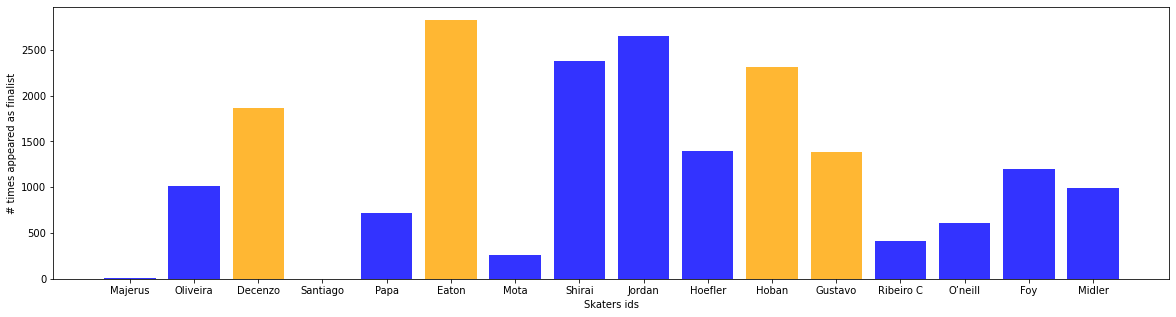

In [55]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from statinlprojekt import Lcq_ids, ids, print_dic
#["Majerus", "Oliveira","Decenzo","Santiago", "Papa", "Eaton", "Mota", "Shirai","Jordan", "Hoefler", "Hoban", "Gustavo", "Ribeiro C", "O’neill", "Foy", "Midler"]

actual_finalists = ["Gustavo", "Hoban", "Eaton", "Decenzo"]

Lcq_ids_index = {Lcq_ids[e]:e for e in range(len(Lcq_ids))}


def get_bayes_params_tricks():
    xparams = {}
    metro_df = pd.read_json('metro_results.json')
    metro_df.set_index('ids',inplace=True)
    for id in Lcq_ids:
        xparams[id]= [metro_df.loc[id]['theta mean'],metro_df.loc[id]['alpha mean'], metro_df.loc[id]['beta mean']]
    return xparams

def get_bayes_params_runs():
    yparams = {}
    metro_df_Y = pd.read_json('for_Y_metro_results.json')
    metro_df_Y.set_index('ids',inplace=True)
    for id in Lcq_ids:
        yparams[id]= [metro_df_Y.loc[id]['alpha mean'], metro_df_Y.loc[id]['beta mean']]
    return yparams


xparams, yparams = get_bayes_params_tricks(), get_bayes_params_runs()

def sort_with_indices(arr):
    indexed_arr = list(enumerate(arr))
    sorted_arr = sorted(indexed_arr, key=lambda x: x[1])
    indices = [index for index, _ in sorted_arr]
    return indices

def total_betyg(tricks, runs):
    sorted_trick = sorted(tricks)
    return (sorted_trick[-2]+sorted_trick[-1]) + max(runs)


def sim_trick_betyg(theta,alpha,beta):
    V = np.array(np.random.choice([0,1], 4, p = [1-theta,theta]))
    Z = np.array(np.random.beta(alpha,beta,4))
    X = [0,0,0,0]
    for i in range(len(X)):
        X[i] = Z[i]*V[i]
    return X


def get_rand_LCQ(): # returns an array of n LCQs. An LCQ is an array representing 
    new_LCQ = {}
    for name in Lcq_ids:
        x_theta,x_alpha,x_beta = xparams[name][0],xparams[name][1],xparams[name][2]
        y_alpha,y_beta = yparams[name][0],yparams[name][1]
        skaters_tricks = sim_trick_betyg(x_theta,x_alpha,x_beta)
        skaters_runs = np.random.beta(y_alpha,y_beta,2)
        new_LCQ[name] = total_betyg(skaters_tricks, skaters_runs)
    return new_LCQ


def get_rand_finalists():
    rand_LCQ = get_rand_LCQ()
    sorted_players = sorted(rand_LCQ.items(), key = lambda x:x[1])
    return [sorted_players[-4][0],sorted_players[-3][0],sorted_players[-2][0],sorted_players[-1][0]]

def most_common_set(set_list):
    set_counts = Counter(frozenset(s) for s in set_list)
    most_common_set, count = set_counts.most_common(1)[0]
    return set(most_common_set), count

def most_common_array(arrays):
    tuple_arrays = [tuple(inner_list) for inner_list in arrays]
    array_counts = Counter(tuple_arrays)
    most_common_tuple, count = array_counts.most_common(1)[0]
    most_common_array = list(most_common_tuple)
    return most_common_array, count


def make_finalist_histogram():
    winner_count = {player : 0 for player in Lcq_ids}
    finalist_array = []
    for i in range(5000):
        new_W = get_rand_finalists()
        finalist_array.append(new_W)
        for e in new_W:
            winner_count[e] += 1

    def disp_most_common_finalists():
        finalist_array_sets = [set(finalists) for finalists in finalist_array]
        actual_finalists_freq = finalist_array_sets.count(set(actual_finalists))
        print("The actual finalists are\n", actual_finalists, " has freq: ", actual_finalists_freq, " which approx equals: ",100*actual_finalists_freq/5000,"%")
        most_common_finalists, freq = most_common_set(finalist_array_sets)
        print("The mode is\n", most_common_finalists, " has freq: ", freq, " which approx equals: ", 100*freq/5000,"%")
    disp_most_common_finalists()

    
    plt.figure(figsize=(20, 5))
    colors = ['orange' if x in actual_finalists else 'blue' for x in Lcq_ids]
    plt.bar(Lcq_ids, [winner_count[name] for name in Lcq_ids], color=colors, alpha=0.8)
    plt.xlabel("Skaters ids")
    plt.ylabel("# times appeared as finalist")
    plt.show()

if __name__=="__main__":
    make_finalist_histogram()


$\textbf{(e)}$ Teori

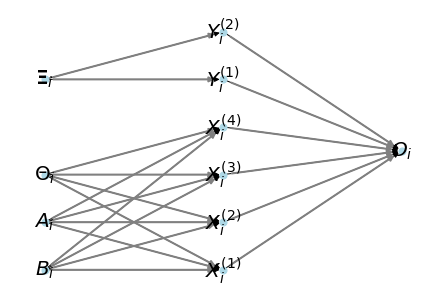

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.DiGraph(directed=True)
# Add nodes with LaTeX labels
G.add_node(1, label=r'$X_i^{(1)}$')
G.add_node(2, label=r'$X_i^{(2)}$')
G.add_node(3, label=r'$X_i^{(3)}$')
G.add_node(4, label=r'$X_i^{(4)}$')
G.add_node(5, label=r'$Y_i^{(1)}$')
G.add_node(6, label=r'$Y_i^{(2)}$')
G.add_node(7, label=r'$\mathbf{\Xi}_i$')
G.add_node(8, label=r'$\Theta_i$')
G.add_node(9, label=r'$A_i$')
G.add_node(10, label=r'$B_i$')
G.add_node(11, label=r'$O_i$')

G.add_edge(7, 5)
G.add_edge(7, 6)
G.add_edge(8,1)
G.add_edge(8,2)
G.add_edge(8,3)
G.add_edge(8,4)
G.add_edge(9,1)
G.add_edge(9,2)
G.add_edge(9,3)
G.add_edge(9,4)
G.add_edge(10,1)
G.add_edge(10,2)
G.add_edge(10,3)
G.add_edge(10,4)
G.add_edge(1,11)
G.add_edge(2,11)
G.add_edge(3,11)
G.add_edge(4,11)
G.add_edge(5,11)
G.add_edge(6,11)
pos = {1: (0, 0), 2: (0, 1), 3: (0, 2), 4:(0,3), 5:(0,4), 6:(0,5), 7:(-1,4), 8:(-1,2),9:(-1,1),10:(-1,0),11:(1,2.5)}

# Draw the graph with LaTeX labels
labels = {node: label for node, label in G.nodes(data='label')}

nx.draw(G, pos, labels=labels, with_labels=True, node_size=50, node_color='lightblue', font_size=20, font_color='black')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# Show the graph
plt.axis('off')
plt.show()


# En Bayesiansk modell med en hierarki

### (a) Beta apriori för $\theta$ 

### (b) Generera utfall
